<a href="https://colab.research.google.com/github/VanshGupta-2404/Deep_Learning_Model_Shape/blob/main/Ayna_ML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# UNet Polygon Coloring - Complete Implementation
# Step 1: Install required packages and setup
!pip install wandb torch torchvision pillow matplotlib tqdm
!pip install -q datasets transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json
import zipfile
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 2: Extract and explore dataset
def extract_dataset():
    """Extract the dataset zip file"""
    with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Dataset extracted successfully!")


    for root, dirs, files in os.walk('/content/dataset'):
        level = root.replace('/content/dataset', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files)-5} more files')

extract_dataset()
print("\n" + "="*50)
print("EXAMINING JSON STRUCTURE")
print("="*50)

with open('/content/dataset/training/data.json', 'r') as f:
    sample_data = json.load(f)

print("Training data structure:")
print(f"Number of items: {len(sample_data)}")
print("Sample items:")
for i, item in enumerate(sample_data[:3]):
    print(f"Item {i}: {item}")

print("\nValidation data structure:")
with open('/content/dataset/validation/data.json', 'r') as f:
    val_data = json.load(f)
print(f"Number of items: {len(val_data)}")
for i, item in enumerate(val_data[:3]):
    print(f"Item {i}: {item}")


In [ ]:

# Step 3: Dataset Class
class PolygonColoringDataset(Dataset):
    def __init__(self, data_dir, transform=None, image_size=256):
        self.data_dir = data_dir
        self.transform = transform
        self.image_size = image_size

        # Load data.json
        with open(os.path.join(data_dir, 'data.json'), 'r') as f:
            self.data = json.load(f)

        # Create color vocabulary - note the key is 'colour' not 'color'
        colors = set()
        for item in self.data:
            colors.add(item['colour'].lower())
        self.color_vocab = {color: idx for idx, color in enumerate(sorted(colors))}
        self.idx_to_color = {idx: color for color, idx in self.color_vocab.items()}

        print(f"Found {len(self.data)} samples")
        print(f"Color vocabulary: {list(self.color_vocab.keys())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_path = os.path.join(self.data_dir, 'inputs', item['input_polygon'])
        input_img = Image.open(input_path).convert('RGB')

        output_path = os.path.join(self.data_dir, 'outputs', item['output_image'])
        target_img = Image.open(output_path).convert('RGB')

        input_img = input_img.resize((self.image_size, self.image_size))
        target_img = target_img.resize((self.image_size, self.image_size))

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        else:
            input_img = transforms.ToTensor()(input_img)
            target_img = transforms.ToTensor()(target_img)

        color_idx = self.color_vocab[item['colour'].lower()]

        return {
            'input_image': input_img,
            'target_image': target_img,
            'color_idx': color_idx,
            'color_name': item['colour'].lower()
        }

In [ ]:
# Step 4: UNet Model Implementation
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match x2 size if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, n_colors=10):
        super(ConditionalUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_colors = n_colors

        self.color_embedding = nn.Embedding(n_colors, 64)
        self.color_proj = nn.Linear(64, 1)

        # UNet encoder - input now has extra channel for color
        self.inc = DoubleConv(n_channels + 1, 64)  # +1 for color channel
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # UNet decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x, color_idx):
        # Embed color
        color_emb = self.color_embedding(color_idx)  # [B, 64]

        color_scalar = self.color_proj(color_emb)  # [B, 1]

        # Create color channel by broadcasting
        B, C, H, W = x.shape
        color_channel = color_scalar.unsqueeze(-1).unsqueeze(-1).expand(B, 1, H, W)

        x_with_color = torch.cat([x, color_channel], dim=1)

        # UNet forward pass
        x1 = self.inc(x_with_color)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return torch.sigmoid(logits)


In [ ]:

# Step 5: Training Setup
def setup_data_loaders(batch_size=8, image_size=256):
    """Setup training and validation data loaders"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = PolygonColoringDataset(
        '/content/dataset/training',
        transform=transform,
        image_size=image_size
    )

    val_dataset = PolygonColoringDataset(
        '/content/dataset/validation',
        transform=transform,
        image_size=image_size
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, train_dataset.color_vocab

def visualize_batch(data_loader, color_vocab):
    """Visualize a batch of data"""
    batch = next(iter(data_loader))

    # Denormalize for visualization
    def denorm(tensor):
        return tensor * 0.5 + 0.5

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(min(4, len(batch['input_image']))):
        # Input image
        input_img = denorm(batch['input_image'][i]).permute(1, 2, 0).cpu()
        axes[0, i].imshow(input_img)
        axes[0, i].set_title(f"Input - {batch['color_name'][i]}")
        axes[0, i].axis('off')

        # Target image
        target_img = denorm(batch['target_image'][i]).permute(1, 2, 0).cpu()
        axes[1, i].imshow(target_img)
        axes[1, i].set_title(f"Target - {batch['color_name'][i]}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

Using device: cuda
Dataset extracted successfully!
dataset/
  .DS_Store
  validation/
    data.json
    outputs/
      green_triangle.png
      blue_octagon.png
      yellow_square.png
      cyan_square.png
      yellow_star.png
    inputs/
      triangle.png
      octagon.png
      star.png
      square.png
  __MACOSX/
    dataset/
      ._.DS_Store
  training/
    data.json
    outputs/
      magenta_pentagon.png
      green_diamond.png
      green_circle.png
      green_octagon.png
      magenta_diamond.png
      ... and 51 more files
    inputs/
      triangle.png
      pentagon.png
      octagon.png
      star.png
      circle.png
      ... and 3 more files
  dataset/
    .DS_Store
    validation/
      data.json
      outputs/
        green_triangle.png
        blue_octagon.png
        yellow_square.png
        cyan_square.png
        yellow_star.png
      inputs/
        triangle.png
        octagon.png
        star.png
        square.png
    training/
      data.json
      outp

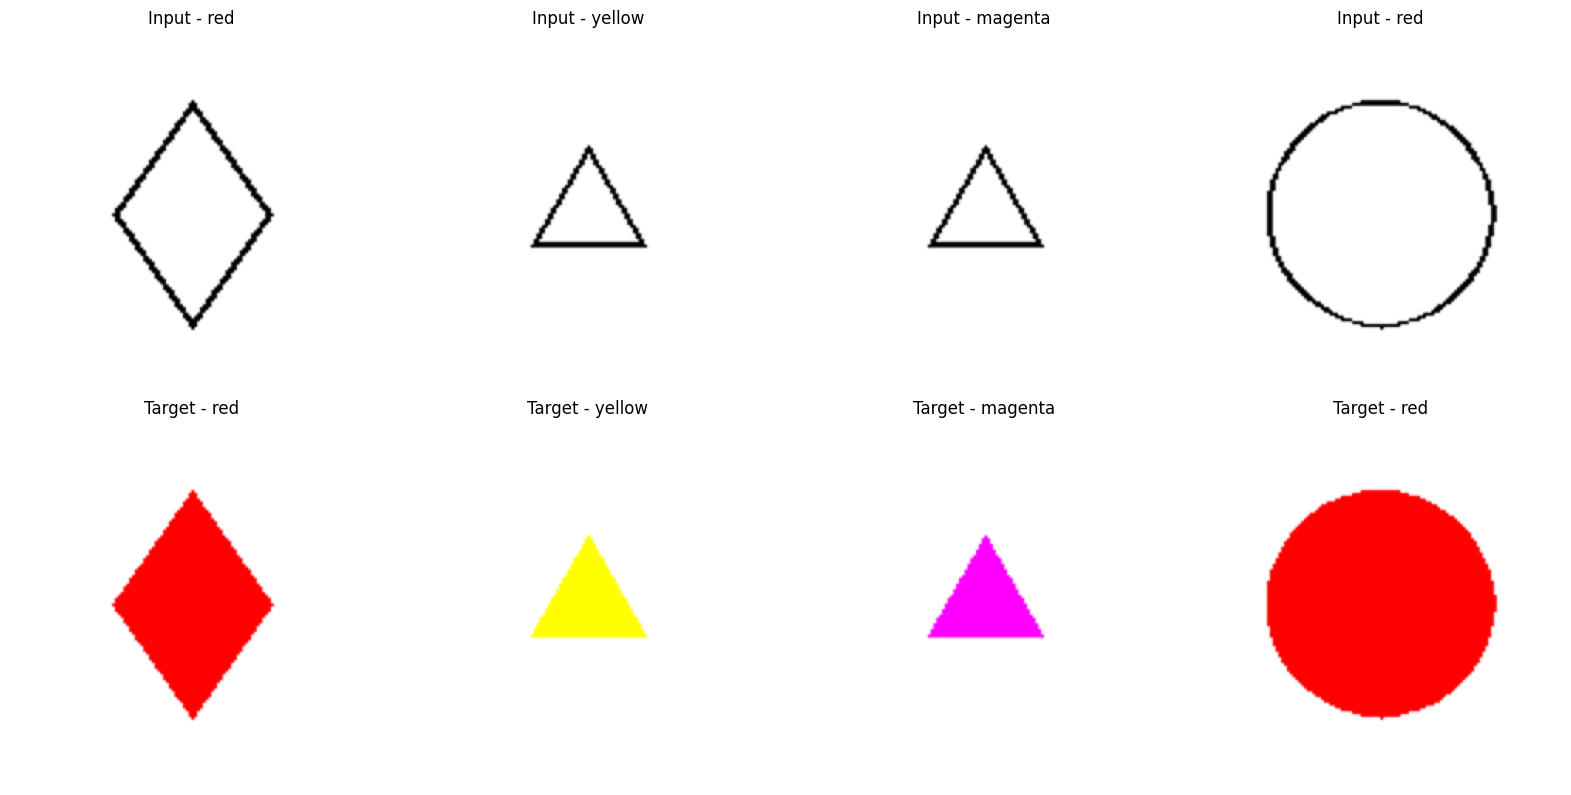

Model initialized with 31044804 parameters
Starting training...


Epoch 1/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, loss=0.35]


Epoch 1: Train Loss: 0.3768, Val Loss: 0.3496
New best model saved with val_loss: 0.3496


Epoch 2/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s, loss=0.285]


Epoch 2: Train Loss: 0.3159, Val Loss: 0.2848
New best model saved with val_loss: 0.2848


Epoch 3/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, loss=0.278]


Epoch 3: Train Loss: 0.2698, Val Loss: 0.2777
New best model saved with val_loss: 0.2777


Epoch 4/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, loss=0.267]


Epoch 4: Train Loss: 0.2456, Val Loss: 0.2674
New best model saved with val_loss: 0.2674


Epoch 5/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=0.194]


Epoch 5: Train Loss: 0.2268, Val Loss: 0.1945
New best model saved with val_loss: 0.1945


Epoch 6/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, loss=0.206]


Epoch 6: Train Loss: 0.2106, Val Loss: 0.2057


Epoch 7/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, loss=0.207]


Epoch 7: Train Loss: 0.1890, Val Loss: 0.2068


Epoch 8/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, loss=0.169]


Epoch 8: Train Loss: 0.1729, Val Loss: 0.1695
New best model saved with val_loss: 0.1695


Epoch 9/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, loss=0.2]


Epoch 9: Train Loss: 0.1598, Val Loss: 0.2003


Epoch 10/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, loss=0.16]


Epoch 10: Train Loss: 0.1654, Val Loss: 0.1602
New best model saved with val_loss: 0.1602


Epoch 11/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, loss=0.216]


Epoch 11: Train Loss: 0.1557, Val Loss: 0.2159


Epoch 12/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, loss=0.175]


Epoch 12: Train Loss: 0.1522, Val Loss: 0.1755


Epoch 13/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.159]


Epoch 13: Train Loss: 0.1448, Val Loss: 0.1587
New best model saved with val_loss: 0.1587


Epoch 14/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, loss=0.151]


Epoch 14: Train Loss: 0.1417, Val Loss: 0.1507
New best model saved with val_loss: 0.1507


Epoch 15/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, loss=0.156]


Epoch 15: Train Loss: 0.1356, Val Loss: 0.1557


Epoch 16/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, loss=0.152]


Epoch 16: Train Loss: 0.1391, Val Loss: 0.1521


Epoch 17/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, loss=0.16]


Epoch 17: Train Loss: 0.1375, Val Loss: 0.1601


Epoch 18/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.147]


Epoch 18: Train Loss: 0.1333, Val Loss: 0.1467
New best model saved with val_loss: 0.1467


Epoch 19/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, loss=0.151]


Epoch 19: Train Loss: 0.1339, Val Loss: 0.1507


Epoch 20/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=0.149]

Epoch 20: Train Loss: 0.1407, Val Loss: 0.1490



Epoch 21/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, loss=0.15]


Epoch 21: Train Loss: 0.1414, Val Loss: 0.1503


Epoch 22/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, loss=0.152]


Epoch 22: Train Loss: 0.1342, Val Loss: 0.1517


Epoch 23/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, loss=0.147]


Epoch 23: Train Loss: 0.1362, Val Loss: 0.1469


Epoch 24/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, loss=0.147]


Epoch 24: Train Loss: 0.1317, Val Loss: 0.1472


Epoch 25/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, loss=0.148]


Epoch 25: Train Loss: 0.1323, Val Loss: 0.1483


Epoch 26/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, loss=0.151]


Epoch 26: Train Loss: 0.1310, Val Loss: 0.1511


Epoch 27/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=0.15]


Epoch 27: Train Loss: 0.1287, Val Loss: 0.1495


Epoch 28/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s, loss=0.147]


Epoch 28: Train Loss: 0.1282, Val Loss: 0.1474


Epoch 29/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, loss=0.148]


Epoch 29: Train Loss: 0.1335, Val Loss: 0.1477


Epoch 30/30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, loss=0.147]

Epoch 30: Train Loss: 0.1275, Val Loss: 0.1472


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,███████████████████████▃▃▃▃▃▃▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▃▃▃▂▃▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning_rate,0.00025
train_loss,0.12753
val_loss,0.14723


Training completed! Model saved as 'best_unet_model.pth'


In [15]:


# Step 6: Training Function
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    """Training loop with wandb logging"""

    # Initialize wandb
    wandb.init(
        project="polygon-coloring-unet",
        config={
            "learning_rate": lr,
            "epochs": num_epochs,
            "batch_size": train_loader.batch_size,
            "architecture": "Conditional UNet",
            "dataset": "Polygon Coloring"
        }
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch in train_bar:
            input_imgs = batch['input_image'].to(device)
            target_imgs = batch['target_image'].to(device)
            color_indices = batch['color_idx'].to(device)

            optimizer.zero_grad()
            outputs = model(input_imgs, color_indices)
            loss = criterion(outputs, target_imgs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch in val_bar:
                input_imgs = batch['input_image'].to(device)
                target_imgs = batch['target_image'].to(device)
                color_indices = batch['color_idx'].to(device)

                outputs = model(input_imgs, color_indices)
                loss = criterion(outputs, target_imgs)
                val_loss += loss.item()
                val_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print(f'New best model saved with val_loss: {avg_val_loss:.4f}')

        if (epoch + 1) % 10 == 0:
            log_predictions(model, val_loader, epoch)

    wandb.finish()
    return model

def log_predictions(model, val_loader, epoch):
    """Log sample predictions to wandb"""
    model.eval()
    batch = next(iter(val_loader))

    with torch.no_grad():
        input_imgs = batch['input_image'][:4].to(device)
        target_imgs = batch['target_image'][:4].to(device)
        color_indices = batch['color_idx'][:4].to(device)

        predictions = model(input_imgs, color_indices)

        # Denormalize for visualization
        def denorm(tensor):
            return torch.clamp(tensor * 0.5 + 0.5, 0, 1)

        # Create wandb images
        wandb_images = []
        for i in range(4):
            input_np = denorm(input_imgs[i]).cpu().permute(1, 2, 0).numpy()
            target_np = denorm(target_imgs[i]).cpu().permute(1, 2, 0).numpy()
            pred_np = denorm(predictions[i]).cpu().permute(1, 2, 0).numpy()

            # Combine images side by side
            combined = np.concatenate([input_np, target_np, pred_np], axis=1)
            wandb_images.append(wandb.Image(
                combined,
                caption=f"Input | Target | Prediction - {batch['color_name'][i]}"
            ))

        wandb.log({f"predictions_epoch_{epoch}": wandb_images})

# Step 7: Main execution
if __name__ == "__main__":

    train_loader, val_loader, color_vocab = setup_data_loaders(batch_size=8, image_size=256)

    # Visualize some data
    print("Visualizing training data...")
    visualize_batch(train_loader, color_vocab)

    # Initialize model
    model = ConditionalUNet(n_channels=3, n_classes=3, n_colors=len(color_vocab))
    model = model.to(device)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Train model
    print("Starting training...")
    trained_model = train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3)

    print("Training completed! Model saved as 'best_unet_model.pth'")

Using device: cuda
Loading trained model...
Model loaded successfully!
Available colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Total colors: 8
TESTING ON VALIDATION SET
Sample 1: star.png + yellow -> yellow_star.png
Sample 2: triangle.png + green -> green_triangle.png
Sample 3: octagon.png + blue -> blue_octagon.png
Sample 4: square.png + yellow -> yellow_square.png
Sample 5: square.png + cyan -> cyan_square.png


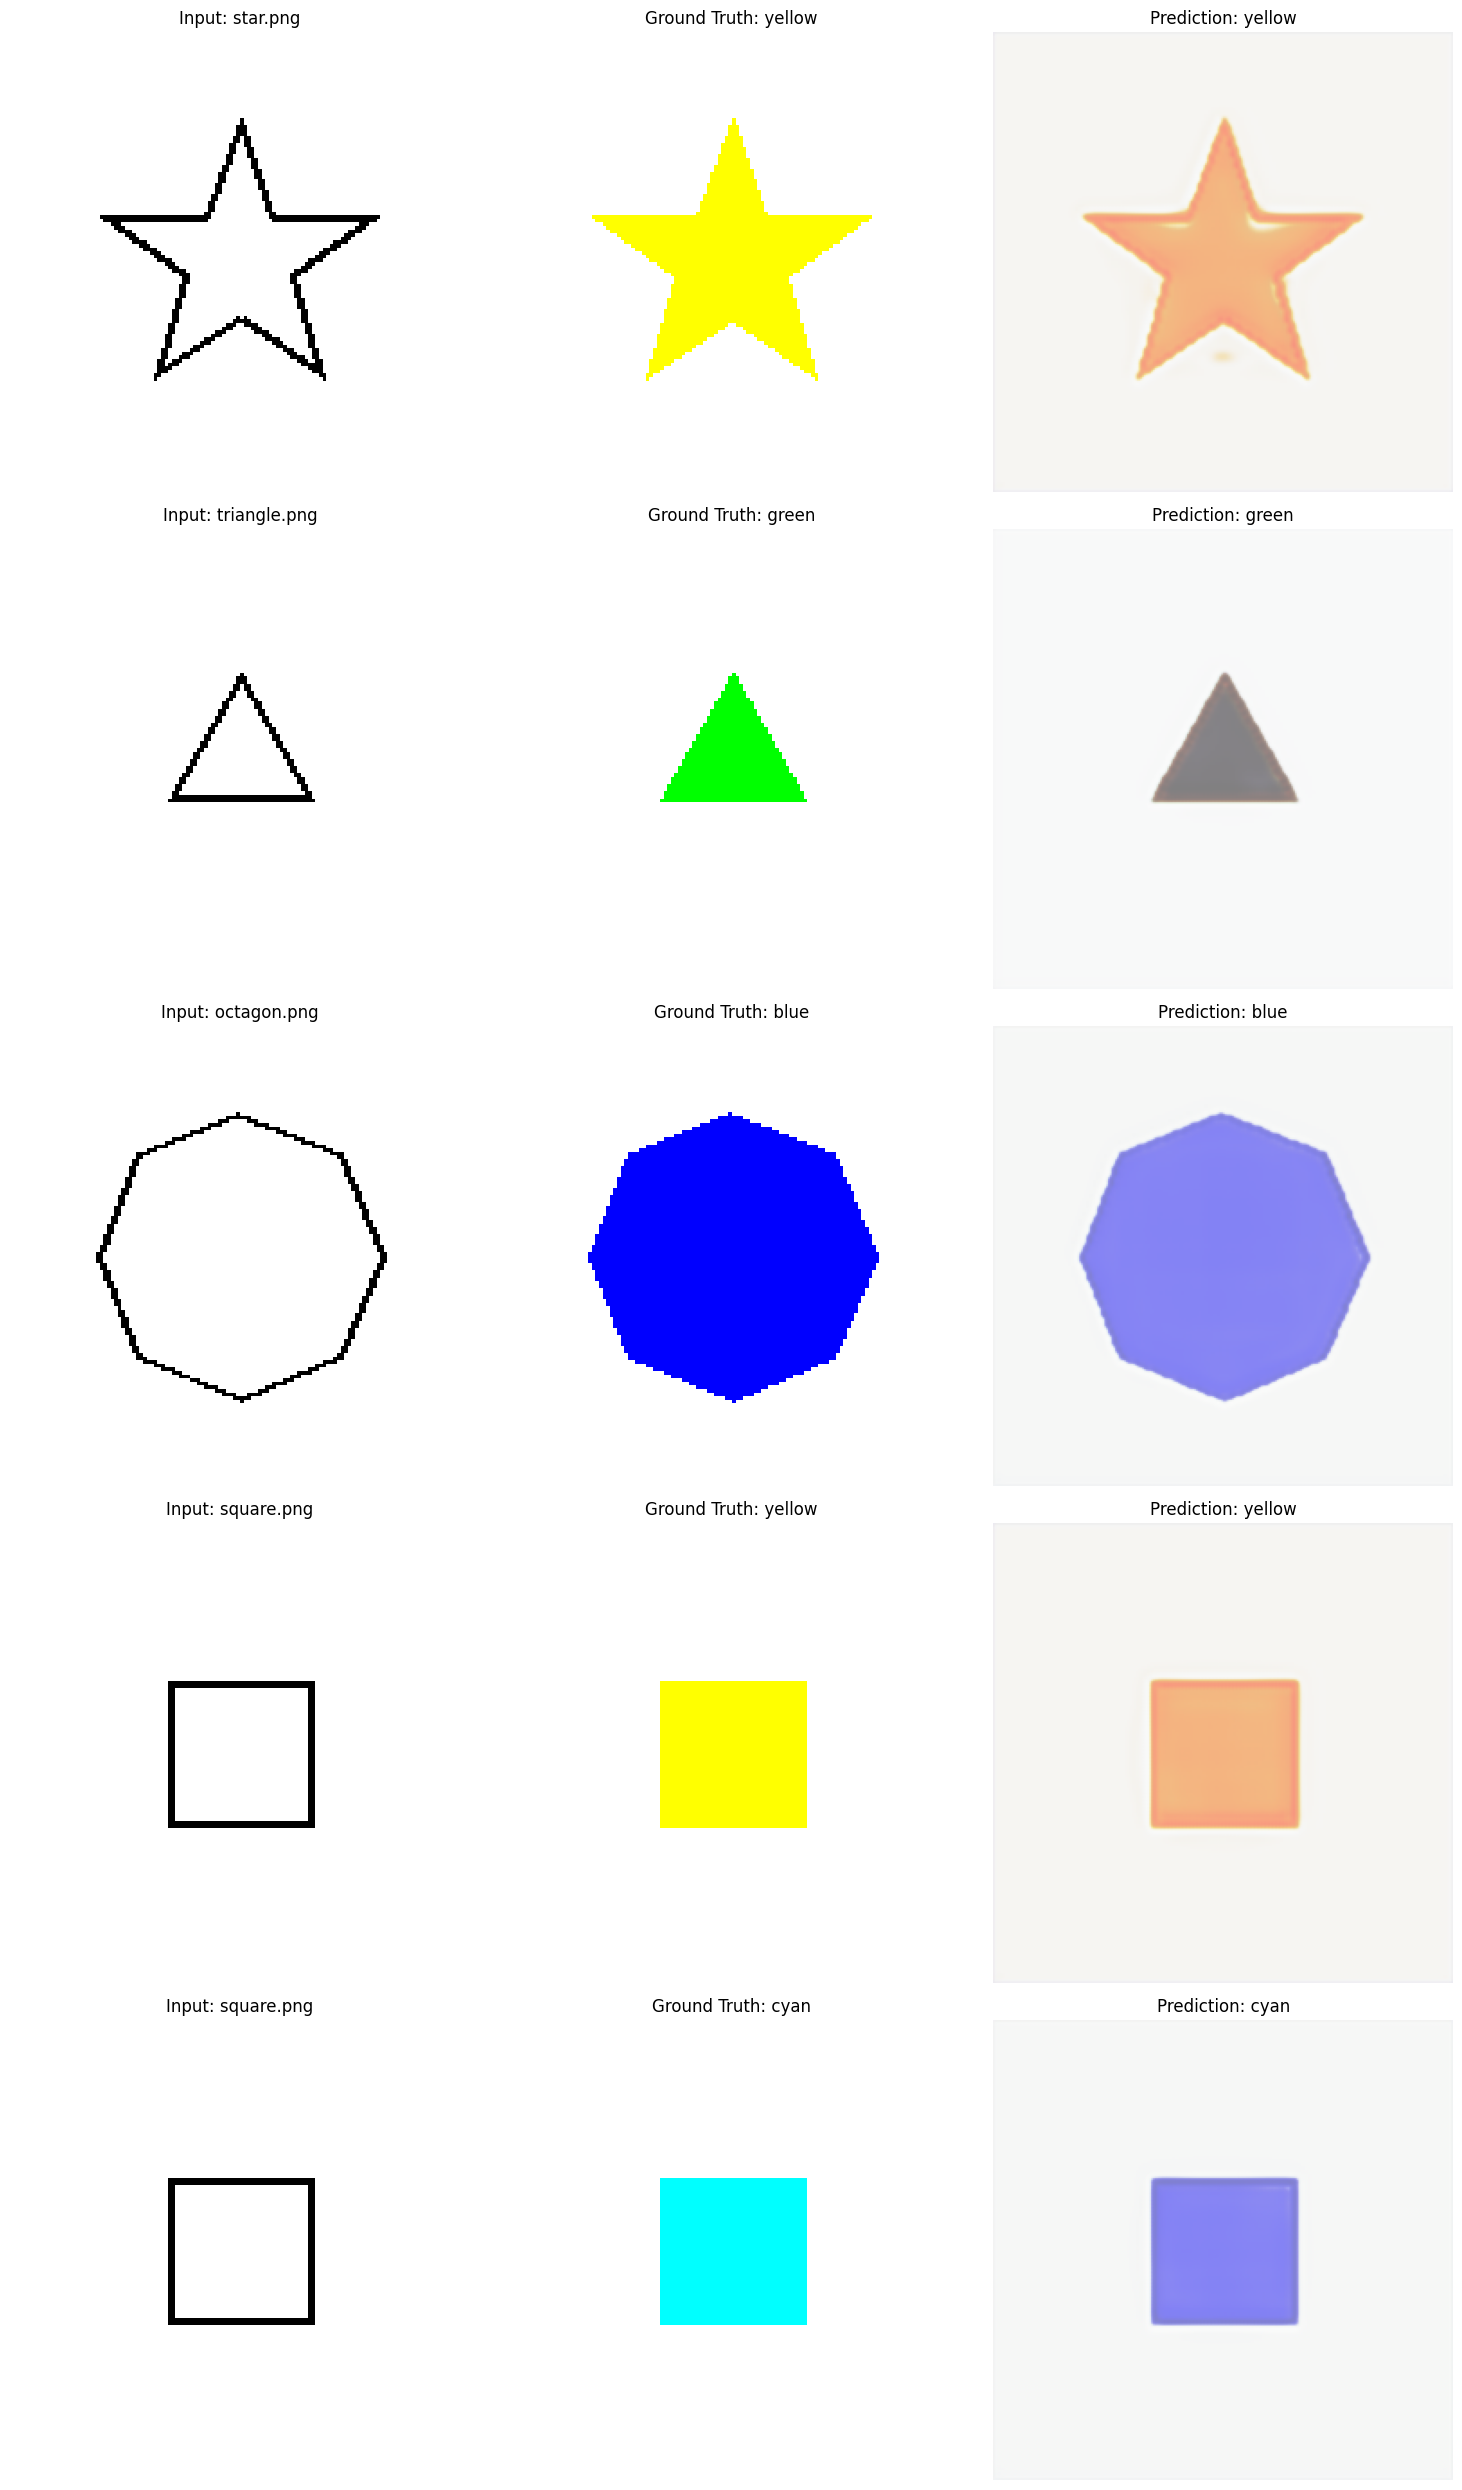

TESTING DIFFERENT COLORS ON SAME SHAPE


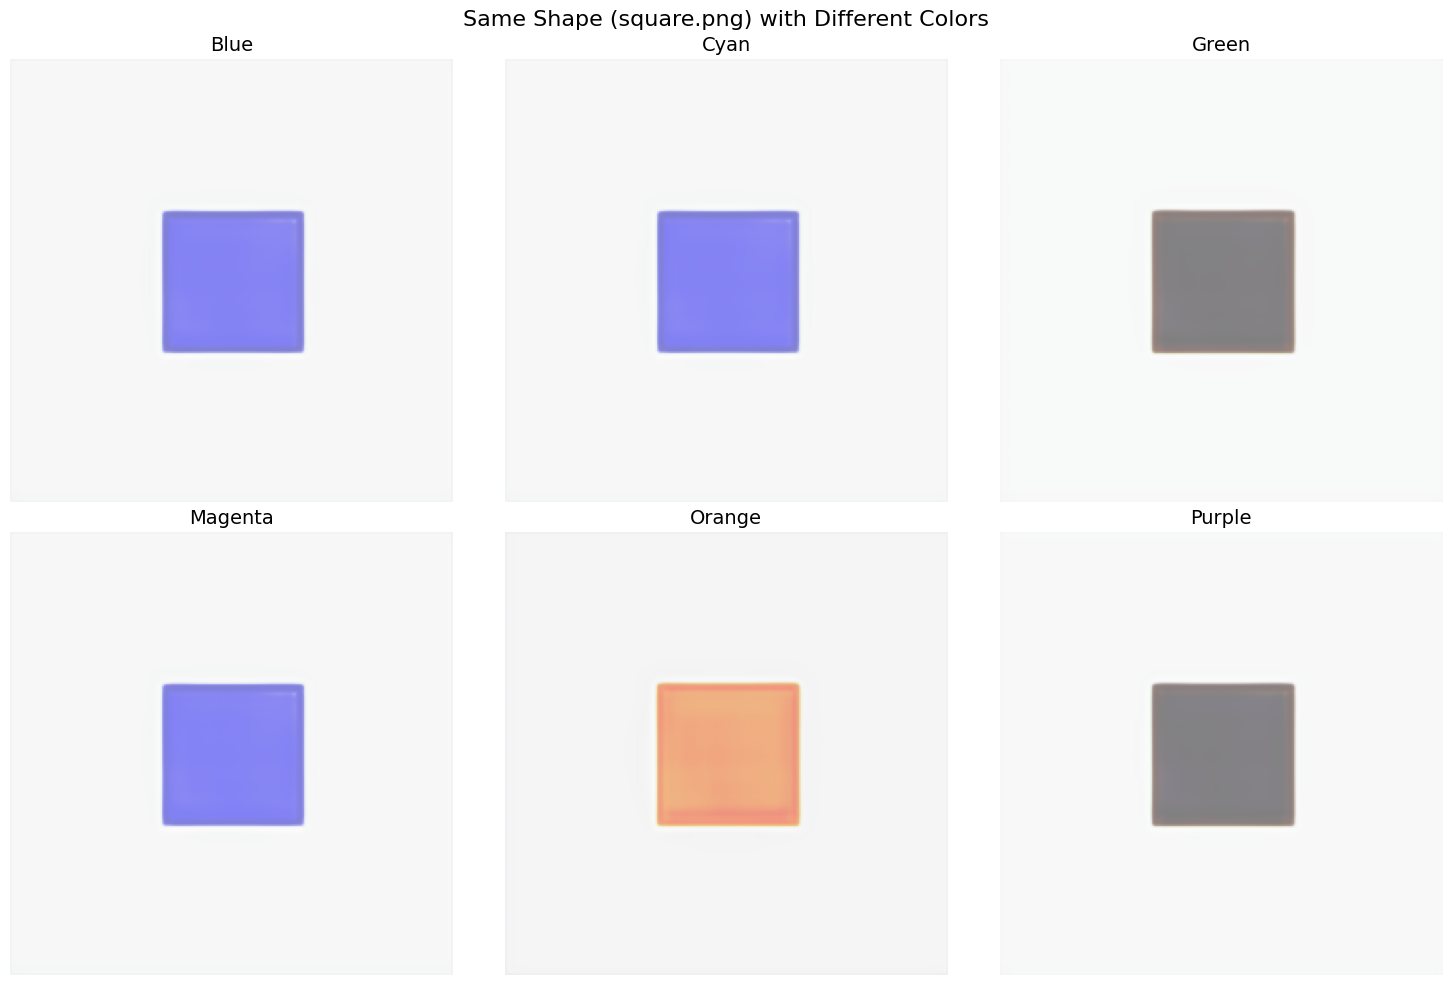

MODEL INFORMATION
Total parameters: 31,044,804
Trainable parameters: 31,044,804
Model size: ~118.4 MB

INFERENCE TESTING COMPLETED!
 Model loaded and tested
 Validation results generated
Color variation tests completed
Images saved: validation_results.png, color_variations.png


In [17]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, n_colors=10):
        super(ConditionalUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_colors = n_colors

        self.color_embedding = nn.Embedding(n_colors, 64)
        self.color_proj = nn.Linear(64, 1)

        self.inc = DoubleConv(n_channels + 1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x, color_idx):
        color_emb = self.color_embedding(color_idx)
        color_scalar = self.color_proj(color_emb)

        B, C, H, W = x.shape
        color_channel = color_scalar.unsqueeze(-1).unsqueeze(-1).expand(B, 1, H, W)
        x_with_color = torch.cat([x, color_channel], dim=1)

        x1 = self.inc(x_with_color)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return torch.sigmoid(logits)

def load_color_vocab():
    with open('/content/dataset/training/data.json', 'r') as f:
        data = json.load(f)

    colors = set()
    for item in data:
        colors.add(item['colour'].lower())

    color_vocab = {color: idx for idx, color in enumerate(sorted(colors))}
    return color_vocab

def load_trained_model():
    color_vocab = load_color_vocab()

    model = ConditionalUNet(n_channels=3, n_classes=3, n_colors=len(color_vocab))
    model.load_state_dict(torch.load('best_unet_model.pth', map_location=device))
    model.to(device)
    model.eval()

    return model, color_vocab

def predict_colored_polygon(model, input_image, color_name, color_vocab, image_size=256):
    if isinstance(input_image, str):
        input_image = Image.open(input_image).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    input_tensor = transform(input_image).unsqueeze(0).to(device)

    color_name = color_name.lower()
    if color_name not in color_vocab:
        raise ValueError(f"Color '{color_name}' not in vocabulary. Available: {list(color_vocab.keys())}")

    color_idx = torch.tensor([color_vocab[color_name]]).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_idx)

    output = output.squeeze(0).cpu()
    output = output * 0.5 + 0.5  # Denormalize
    output = torch.clamp(output, 0, 1)

    output_pil = transforms.ToPILImage()(output)
    return output_pil

# Test on validation set
def test_validation_samples(model, color_vocab, num_samples=5):
    print("=" * 60)
    print("TESTING ON VALIDATION SET")
    print("=" * 60)

    with open('/content/dataset/validation/data.json', 'r') as f:
        val_data = json.load(f)

    fig, axes = plt.subplots(len(val_data), 3, figsize=(15, 5*len(val_data)))
    if len(val_data) == 1:
        axes = axes.reshape(1, -1)

    for i, sample in enumerate(val_data):
        input_path = f"/content/dataset/validation/inputs/{sample['input_polygon']}"
        input_img = Image.open(input_path).convert('RGB')

        target_path = f"/content/dataset/validation/outputs/{sample['output_image']}"
        target_img = Image.open(target_path).convert('RGB')

        pred_img = predict_colored_polygon(model, input_img, sample['colour'], color_vocab)

        # Display
        axes[i, 0].imshow(input_img)
        axes[i, 0].set_title(f'Input: {sample["input_polygon"]}', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(target_img)
        axes[i, 1].set_title(f'Ground Truth: {sample["colour"]}', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_img)
        axes[i, 2].set_title(f'Prediction: {sample["colour"]}', fontsize=12)
        axes[i, 2].axis('off')

        print(f"Sample {i+1}: {sample['input_polygon']} + {sample['colour']} -> {sample['output_image']}")

    plt.tight_layout()
    plt.savefig('validation_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    return val_data

def test_different_colors(model, color_vocab):
    print("=" * 60)
    print("TESTING DIFFERENT COLORS ON SAME SHAPE")
    print("=" * 60)

    input_path = "/content/dataset/validation/inputs/square.png"
    if not os.path.exists(input_path):

        input_files = os.listdir("/content/dataset/validation/inputs")
        input_path = f"/content/dataset/validation/inputs/{input_files[0]}"

    input_img = Image.open(input_path).convert('RGB')

    colors_to_test = list(color_vocab.keys())[:6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, color in enumerate(colors_to_test):
        if i >= 6:
            break

        pred_img = predict_colored_polygon(model, input_img, color, color_vocab)

        axes[i].imshow(pred_img)
        axes[i].set_title(f'{color.title()}', fontsize=14)
        axes[i].axis('off')

    if len(colors_to_test) < 6:
        axes[-1].imshow(input_img)
        axes[-1].set_title('Original Input', fontsize=14)
        axes[-1].axis('off')

    plt.suptitle(f'Same Shape ({os.path.basename(input_path)}) with Different Colors', fontsize=16)
    plt.tight_layout()
    plt.savefig('color_variations.png', dpi=150, bbox_inches='tight')
    plt.show()

def run_inference_tests():
    print("Loading trained model...")
    model, color_vocab = load_trained_model()

    print(f"Model loaded successfully!")
    print(f"Available colors: {list(color_vocab.keys())}")
    print(f"Total colors: {len(color_vocab)}")

    val_results = test_validation_samples(model, color_vocab)

    test_different_colors(model, color_vocab)

    print("=" * 60)
    print("MODEL INFORMATION")
    print("=" * 60)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: ~{total_params * 4 / (1024**2):.1f} MB")

    return model, color_vocab, val_results

# Run all tests
if __name__ == "__main__":
    model, color_vocab, val_results = run_inference_tests()

    print("\n" + "=" * 60)
    print("INFERENCE TESTING COMPLETED!")
    print("=" * 60)
    print(" Model loaded and tested")
    print(" Validation results generated")
    print("Color variation tests completed")
    print("Images saved: validation_results.png, color_variations.png")
